In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

In [55]:
df = pd.read_csv("E:\Internship\clean_data (1).zip")

In [56]:
df.head()

,label,text,label_num,char_length,word_count,avg_word_length,clean_text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,327,67,4.880597,subject enron methanol meter follow note gave ...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,97,23,4.217391,subject hpl nom january see attached file hpln...
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,2524,550,4.589091,subject neon retreat ho ho ho around wonderful...
3,spam,"Subject: photoshop , windows , office . cheap ...",1,414,48,8.625000,subject photoshop window office cheap main tre...
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,336,70,4.800000,subject indian spring deal book teco pvr reven...


In [57]:
df.isnull().sum()

label              0
text               0
label_num          0
char_length        0
word_count         0
avg_word_length    0
clean_text         0
dtype: int64

Basic Dataset Overview

In [58]:
print(f"Dataset Shape:{df.shape}")
print("\nClass Distribtuion:")
print(df['label'].value_counts())

Dataset Shape:(5171, 7)

Class Distribtuion:
label
ham     3672
spam    1499
Name: count, dtype: int64


Visualise Class Balance

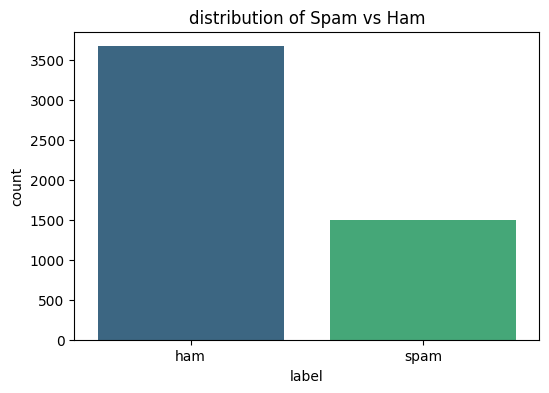

In [59]:
plt.figure(figsize=(6,4)) 
sns.countplot(x='label',data = df, palette='viridis',hue='label')
plt.title('distribution of Spam vs Ham')
plt.show()

Feature Engineering for Analysis

In [60]:
len (df['clean_text'][0].split())

31

In [61]:
df['char_count'] = df['clean_text'].apply(len)
#2.Word Count
df['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))
#3. Average Word Length
df['avg_word_len'] = df['char_count'] / (df['word_count'] + 1)

In [62]:
#Statistical Summary by label
df.groupby('label') [['char_count', 'word_count', 'avg_word_len']].describe()

char_count                                                       \
           count        mean          std   min     25%    50%    75%   
label                                                                   
ham       3672.0  558.715686   835.074284  12.0  130.75  282.5  676.0   
spam      1499.0  842.811207  1358.294195   7.0  177.00  374.0  830.5   

               word_count              ...                avg_word_len  \
           max      count        mean  ...    75%     max        count   
label                                  ...                               
ham    20364.0     3672.0   86.363017  ...  105.0  3302.0       3672.0   
spam   21384.0     1499.0  117.194129  ...  116.5  2589.0       1499.0   

                                                                              
           mean       std       min       25%       50%       75%        max  
label                                                                         
ham    6.147053  0.743526  3.666667  5.690476  6.206897  6.645191   8.566802  
spam   6.631511  1.040947  3.500000  6.000000  6.647059  7.251667  11.780488  

[2 rows x 24 columns]

Visualising Distribution Differences

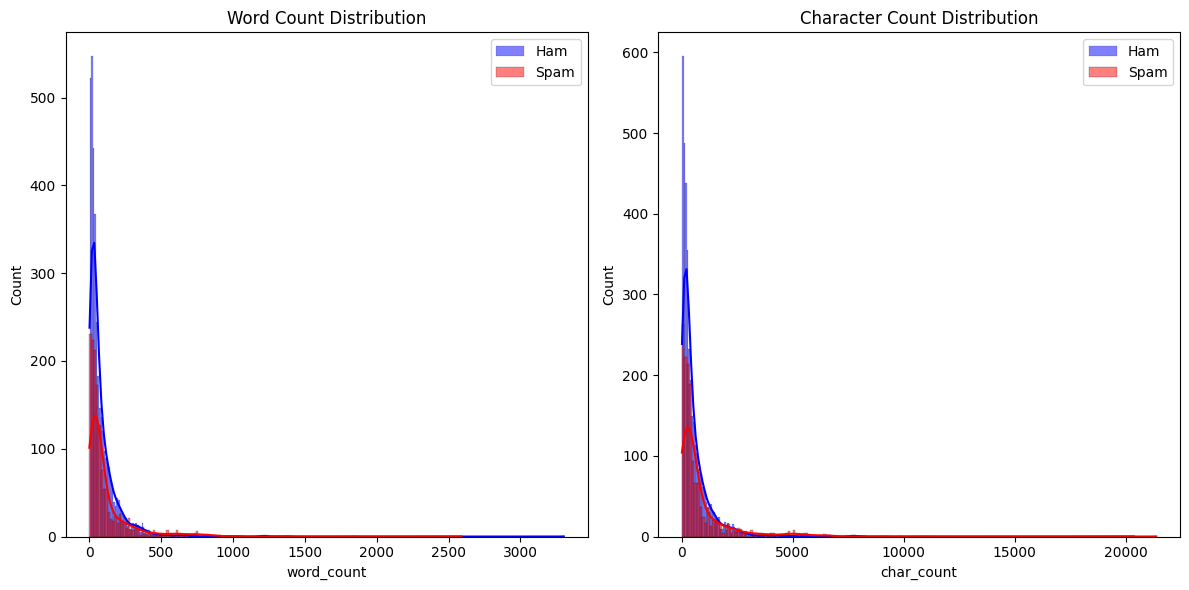

In [63]:
plt.figure(figsize=(12,6))
#Plotting Word Count Distribution
plt.subplot(1,2,1)
sns.histplot(df[df['label'] == 'ham']['word_count'], label ='Ham', kde=True, color='blue')
sns.histplot(df[df['label'] == 'spam']['word_count'], label ='Spam', kde=True, color='red')
plt.title('Word Count Distribution')
plt.legend()

#Plotting Character Count Distribution
plt.subplot(1,2,2)
sns.histplot(df[df['label'] == 'ham']['char_count'], label ='Ham', kde=True, color='blue')
sns.histplot(df[df['label'] == 'spam']['char_count'], label ='Spam', kde=True, color='red')
plt.title('Character Count Distribution')
plt.legend()

plt.tight_layout()
plt.show()

Word Clouds

In [66]:
def generate_wordcloud(data,title):
    wc= WordCloud(width=800, height=400, background_color='white', max_words=100).generate(" ".join(data))
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

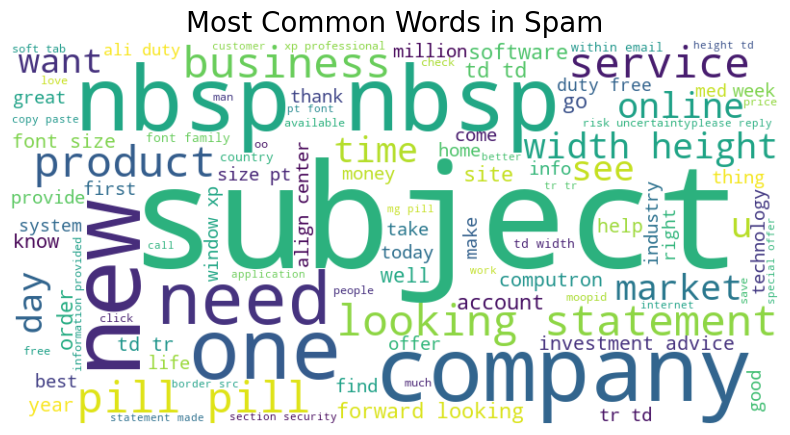

In [67]:
#Wordcloud for spam
generate_wordcloud(df[df['label']== 'spam']['clean_text'], "Most Common Words in Spam")

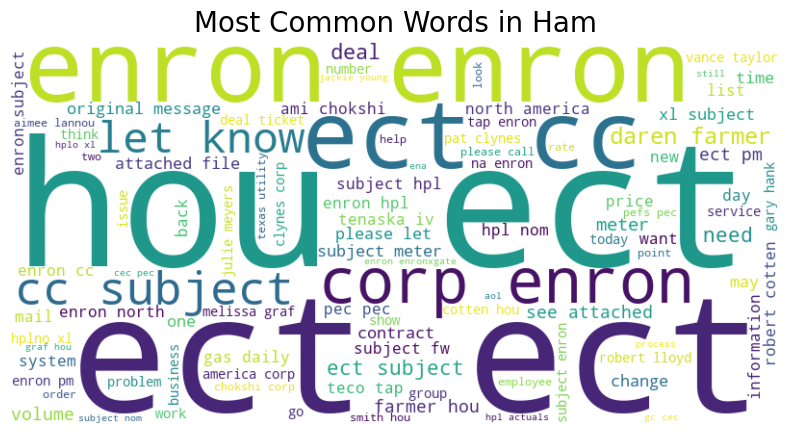

In [68]:
#Wordcloud for Ham
generate_wordcloud(df[df['label']== 'ham']['clean_text'], "Most Common Words in Ham")

MODEL TRAINING AND INTERFACE
PRE PROCESSING AND SPLITTING 

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [70]:
le = LabelEncoder()
df['label_num']=le.fit_transform(df['label'])

DEFINE X & Y

In [71]:
x=df['clean_text']
y=df['label_num']

In [72]:
x

0       subject enron methanol meter follow note gave ...
1       subject hpl nom january see attached file hpln...
2       subject neon retreat ho ho ho around wonderful...
3       subject photoshop window office cheap main tre...
4       subject indian spring deal book teco pvr reven...
                              ...                        
5166    subject put ft transport volume decreased cont...
5167    subject following noms hpl take extra mmcf wee...
5168    subject calpine daily gas nomination julie men...
5169    subject industrial worksheet august activity a...
5170    subject important online banking alert dear va...
Name: clean_text, Length: 5171, dtype: object

In [73]:
y

0       0
1       0
2       0
3       1
4       0
       ..
5166    0
5167    0
5168    0
5169    0
5170    1
Name: label_num, Length: 5171, dtype: int64

In [81]:
#Split the data (80% training,20% testing)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=12,stratify=y)
print(f"Training sample: (len(x_train))")
print(f"Testing sample: (len(x_test))")


Training sample: (len(x_train))
Testing sample: (len(x_test))


BUILDING THE PIPELINE (TF-IDF+LogisticRegression)

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [83]:
model_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('nb', LogisticRegression())
])    

In [84]:
#train the model 
model_pipeline.fit(x_train,y_train)
print("Model training complete")

Model training complete


Evaluating Model Performance


In [85]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [86]:
#make predictions on the test set 
y_pred = model_pipeline.predict(x_test)


In [87]:
#Print Metrics
print("---Classification Report---")
print(classification_report(y_test,y_pred,target_names=le.classes_))

---Classification Report---
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       735
        spam       0.95      0.98      0.97       300

    accuracy                           0.98      1035
   macro avg       0.97      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



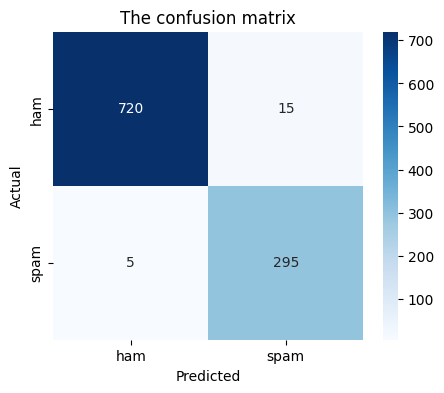

In [89]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cmap='Blues',
            xticklabels=le.classes_,yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('The confusion matrix')
plt.show()